In [1]:
#Importando bibliotecas a serem utilizadas no projeto
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_distances
from sklearn.neighbors import NearestNeighbors
from collections import defaultdict
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import KFold

In [2]:
# Carregando dataset contendo os títulos dos filmes
arquivo = "./dataset/movies.csv"
movies = pd.read_csv(arquivo)
# Carregando dataset contendo a avaliação dos filmes
arquivo2 = "./dataset/ratings.csv"
ratings = pd.read_csv(arquivo2)

In [3]:
# Variáveis disponíveis nos datasets
print('Variáveis do dataset movies: ', movies.columns.values)
print('Variáveis do dataset ratings: ', ratings.columns.values)

Variáveis do dataset movies:  ['movieId' 'title' 'genres']
Variáveis do dataset ratings:  ['userId' 'movieId' 'rating' 'timestamp']


In [4]:
# Mesclando os 2 datasets em um único, associado pela variável movieId
data = ratings.merge(movies, on='movieId')
data.head(5)

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [5]:
data = data.drop('timestamp', axis = 1)
data.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


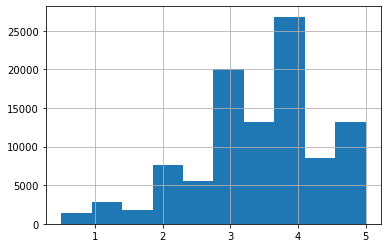

In [6]:
# Histograma das avaliações
data.rating.hist()

In [7]:
# Calculando a quantidade de avaliações dadas por cada usuário
data['count'] = data.apply(lambda x: data[data['userId']==x[0]].shape[0], axis = 1)

In [8]:
# Agrupamento, informando a média das avaliações de cada usuário e ordenando pela quantidade de filmes avaliados
data.groupby('userId')['rating','count'].mean().sort_values(by='count', ascending = False).head(10)

,rating,count
userId,,
414,3.391957,2698
599,2.642050,2478
474,3.398956,2108
448,2.847371,1864
274,3.235884,1346
610,3.688556,1302
68,3.233730,1260
380,3.673235,1218
606,3.657399,1115


In [9]:
# Filmes avaliados pelo userId 500
data[data['userId']==500].sort_values(by='rating', ascending = False).head(20)

,userId,movieId,rating,title,genres,count
34508,500,1784,5.0,As Good as It Gets (1997),Comedy|Drama|Romance,86
60205,500,1747,5.0,Wag the Dog (1997),Comedy,86
34866,500,3114,5.0,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,86
19271,500,176,5.0,Living in Oblivion (1995),Comedy,86
69963,500,1175,5.0,Delicatessen (1991),Comedy|Drama|Romance,86
14839,500,2997,5.0,Being John Malkovich (1999),Comedy|Drama|Fantasy,86
61602,500,2355,5.0,"Bug's Life, A (1998)",Adventure|Animation|Children|Comedy,86
14016,500,2858,5.0,American Beauty (1999),Drama|Romance,86
13560,500,2700,5.0,"South Park: Bigger, Longer and Uncut (1999)",Animation|Comedy|Musical,86
12628,500,2542,5.0,"Lock, Stock & Two Smoking Barrels (1998)",Comedy|Crime|Thriller,86


In [10]:
# Verificando se o dataset possui valores missing
data.isna().sum()

userId     0
movieId    0
rating     0
title      0
genres     0
count      0
dtype: int64

In [11]:
# Convertendo o dataset em uma matriz esparsa, com os valores missing substituídos por 0 
# (lembrando que 0 não é a avaliação do filme, e sim que o usuário ainda não avalou)
data2 = data.pivot(index='userId', columns='movieId', values='rating').fillna(0)
data2.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Convertendo dataframe em array
data3 = data2.to_numpy()
data3

array([[4. , 0. , 4. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [2.5, 2. , 2. , ..., 0. , 0. , 0. ],
       [3. , 0. , 0. , ..., 0. , 0. , 0. ],
       [5. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [13]:
#Calculando a Esparsidade - Taxa ( em % ) de valores diferentes de zero na matriz
sparsity = float(len(data3.nonzero()[0]))
sparsity /= (data3.shape[0] * data3.shape[1])
sparsity *= 100 
print('Esparsidade: {:4.2f}%'.format(sparsity))

Esparsidade: 1.70%


In [14]:
# Dividindo os arrays em dados de treino e teste ( 70% Treino e 30% Teste )
train, test = train_test_split(data3, test_size = 0.3, random_state = 158)
train.shape

(427, 9724)

In [15]:
# Calculando a similaridade de cossenos entre cada usuário
dist_out = 1 - cosine_distances(train)
dist_out

array([[1.        , 0.06358911, 0.21197785, ..., 0.18282331, 0.08234365,
        0.01986435],
       [0.06358911, 1.        , 0.0951586 , ..., 0.10358461, 0.03223509,
        0.05648592],
       [0.21197785, 0.0951586 , 1.        , ..., 0.23088958, 0.06762014,
        0.04386099],
       ...,
       [0.18282331, 0.10358461, 0.23088958, ..., 1.        , 0.09244495,
        0.05746391],
       [0.08234365, 0.03223509, 0.06762014, ..., 0.09244495, 1.        ,
        0.07196013],
       [0.01986435, 0.05648592, 0.04386099, ..., 0.05746391, 0.07196013,
        1.        ]])

In [16]:
# Cálculo dos ratings predistos
user_pred = dist_out.dot(train) / np.array([np.abs(dist_out).sum(axis=1)]).T
user_pred

array([[1.69867448, 0.79935061, 0.19924843, ..., 0.00803672, 0.00803672,
        0.01998879],
       [1.5472915 , 1.02609205, 0.34885273, ..., 0.        , 0.        ,
        0.00203823],
       [1.68358809, 0.78095211, 0.26467931, ..., 0.00187757, 0.00187757,
        0.01448093],
       ...,
       [1.66710045, 0.79128992, 0.23423719, ..., 0.00178872, 0.00178872,
        0.01640912],
       [1.64762897, 0.75156374, 0.24685315, ..., 0.        , 0.        ,
        0.00496233],
       [1.60595987, 0.79989039, 0.29527151, ..., 0.00295178, 0.00295178,
        0.00264405]])

In [17]:
# Função para obter as métricas
# Usaremos o MSE (Mean Square Error) para avaliar os erros comparando valores atuais e valores previstos
# Quanto menor, melhor!
def get_mse(pred, atual):
    pred = pred[atual.nonzero()].flatten()
    atual = atual[atual.nonzero()].flatten()
    return mean_squared_error(pred, atual)

In [18]:
# Avaliando as predições nos dados de treino
get_mse(user_pred, train)

9.337427733413215

In [19]:
# Avaliando as predições nos dados de teste
get_mse(user_pred, test)

10.832280619314165

Como podemos observar, o valor do MSE ficou alto, o que nos leva a testart outros algoritmos visando diminuir os erros nas predições do modelo.

A provável causa do valor alto para os erros, pode ter sido o fato de usarmos todos os ratings em nossos cálculos. Vamos agora usar apenas os "top 5 usuários similares" enquanto estivermos preparando nossas predições.

Para isso, vamos usar o modelo KNN e usar uma medida de similaridade (cosine) para encontrar o "top 5 usuários similares".

In [20]:
# Definir o objeto NearestNeighbors passando k (=5) como parâmetro e definindo o método de similaridade para criar o modelo
k = 5
modelo = NearestNeighbors(k,'cosine')
modelo.fit(train)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius='cosine')

In [21]:
# Extraindo os usuários top 5 em similaridade
top_k_distances, top_k_users = modelo.kneighbors(train, return_distance = True)

In [22]:
# Preparando a matriz de zeros
user_pred_k = np.zeros(train.shape)

In [23]:
# Fazendo as predições
for i in range(train.shape[0]):
  user_pred_k[i,:] = top_k_distances[i].T.dot(train[top_k_users][i])/np.array([np.abs(top_k_distances[i].T).sum(axis=0)]).T

In [24]:
get_mse(user_pred_k, train)

10.500998736279277

In [25]:
get_mse(user_pred_k, test)

12.797212587696077

Notamos que utilizando o algoritmo KNN o nosso modelo teve uma piora na métrica dos erros.

Como nossa matriz possui muitos valores esparsos, iremos utilizar a técnica de Redução de Dimensionalidade, aplicando o algoritmo SVD, que se adapta muito bem a matrizes esparsas.

In [26]:
# Tentando diminuir o erro aplicando o algoritmo SVD para fazer as predições

def get_top_n(predictions, n=10):
    '''Retorna as n maiores recomendações para cada usuário de um conjunto de predições.

    Argumentos:
        predictions(lista de objetos de Predição): A lista das predições, retornado pelo 
        método de teste do algoritmo.
        n(int): O número de recomendações para cada usuário. O padrão é 10.

    Retorna:
        Um dicionário onde as chaves são os usuários (raw) e os valores são listas de tuplas:
        [(raw item id, rating estimation), ...] do tamanho n.
    '''

    # Primeiro, mapeie as predições de cada usuário
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Então ordene as predições para cada usuário e obtenha as k maiores.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


# Primeiro treino o algoritmo SVD com o dataset
reader = Reader()
data_ = Dataset.load_from_df(data[['userId', 'title', 'rating']], reader)
trainset = data_.build_full_trainset()
algo = SVD()
algo.fit(trainset)

# E então predite as avaliações para todos os pares (u, i) que não estão no conjunto de treino.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=20)

In [27]:
# Função para calcular as predições de um usuário 
def recommended(userID, n=10):
    for uid, user_ratings in top_n.items():
        if uid == userID:
            print(uid, [iid for (iid, _) in user_ratings])

# Fazendo predições ( userId = 500, 20 recomendações )
recommended = recommended(500, n=20)

500 ['Harold and Maude (1971)', 'Up (2009)', 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)', 'Alien (1979)', 'His Girl Friday (1940)', 'Lawrence of Arabia (1962)', 'Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)', 'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)', 'Seven (a.k.a. Se7en) (1995)', 'Great Escape, The (1963)', 'Lord of the Rings: The Fellowship of the Ring, The (2001)', 'Perks of Being a Wallflower, The (2012)', 'Femme Nikita, La (Nikita) (1990)', 'Prestige, The (2006)', 'Graduate, The (1967)', 'Pulp Fiction (1994)', 'Lord of the Rings: The Return of the King, The (2003)', 'Bridge on the River Kwai, The (1957)', 'Little Big Man (1970)', 'Third Man, The (1949)']


In [28]:
# Calculando o RMSE do nosso modelo já treinado ( SVD )

# Dividindo o dataset em 5 partes com o KFold
kf = KFold(n_splits = 5)

# Usando o algoritmo SVD.
algo = SVD()

# Calculando o RMSE do nosso modelo.
for trainset, testset in kf.split(data_):
    algo.fit(trainset)
    predictions = algo.test(testset)    
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.8729
RMSE: 0.8776
RMSE: 0.8714
RMSE: 0.8761
RMSE: 0.8713


Como podemos observar, utilizando o algoritmo SVD no nosso modelo, o erro nas predições diminuiu consideravelmente, tornando o modelo mais preciso nas suas predições.